In [ ]:
import sklearn.decomposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This is only for the stock `stock_id=0`.

In [ ]:
book_df = pd.read_parquet("./data/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet")
trade_df = pd.read_parquet("./data/trade_train.parquet/stock_id=0/ef805fd82ff54fadb363094e3b122ab9.parquet")

target_df = pd.read_csv("./data/train.csv")
# the target_df contains all stocks. The following line restricts it to stock_id=0 and drops the label, since it's not relevant
target_df = target_df[target_df.stock_id == 0].drop('stock_id', axis=1)

FileNotFoundError: ignored

In the following `book_df`, there are many 10-minute windows/buckets of data. The row number is meaningless. Each `time_id` corresponds to *one* bucket, and `seconds_in_bucket` is how far into that bucket the observation is. There are gaps in `time_id` and `seconds_in_bucket`. The gaps in `seconds_in_bucket` means that we do not have access to a complete second-by-second record of the order book. Many records are left out. In this dataframe, there are 8 features once the `time_id` and `seconds_in_bucket` have been specified. Note that `seconds_in_bucket` 0 is always present, but all other times may or may not be. In fact, I checked, and every second other than 0 is missing in at least one bucket. And every second from 0-599 is present in at least one bucket.

In [ ]:
book_df.head()

NameError: ignored

The dataframe `trade_df` is very similar. Each row represents one trade. There are just 3 features here.

In [ ]:
trade_df.head()

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1


Finally, the target data in `target_df` contains the actual realized volatility information , called `target`, from 10 minutes in the future. This is what we want to predict. The dataframe has all the `stock_id`s but we only care about `stock_id=0`. The `time_id` is again the bucket we care about. I'll restrict it to `stock_id=0` for convenience.

In [ ]:
target_df.head()

,time_id,target
0,5,0.004136
1,11,0.001445
2,16,0.002168
3,31,0.002195
4,62,0.001747


For the `book_df` dataframe, I am going to fill in the missing seconds with the data from the most recent second. For example, if is data at seconds 0, 4, and 7, then I will give seconds 1-3 the data from second 0, and seconds 5-6 the data from second 4.

In [ ]:
# get a list of all time buckets and seconds , without repetitions
unique_times = book_df['time_id'].drop_duplicates().to_frame()
unique_seconds = book_df['seconds_in_bucket'].drop_duplicates().sort_values().to_frame()

# take the cross of these. So all possible (bucket, second) pairs are present
full_book_df = unique_times.merge(unique_seconds, how='cross')

# filling in the seconds data requires things to be sorted by seconds
full_book_df = full_book_df.sort_values(['seconds_in_bucket', 'time_id'])
book_sorted_df = book_df.sort_values('seconds_in_bucket')

# This actually fills things in. 'on' means fill in seconds, 'by' means do it for each time_id.
full_book_df = pd.merge_asof(left=full_book_df, right=book_sorted_df, on='seconds_in_bucket', by='time_id')

# go back to our original order
full_book_df = full_book_df.sort_values(['time_id', 'seconds_in_bucket']).reset_index(drop=True)

Now we see that all seconds are present. There are changes at seconds 1, 5, 6.

In [ ]:
full_book_df.head(10)

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100
2,5,2,1.001422,1.002301,1.00137,1.002353,3,100,2,100
3,5,3,1.001422,1.002301,1.00137,1.002353,3,100,2,100
4,5,4,1.001422,1.002301,1.00137,1.002353,3,100,2,100
5,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100
6,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100
7,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100
8,5,8,1.001422,1.002301,1.00137,1.002405,3,126,2,100
9,5,9,1.001422,1.002301,1.00137,1.002405,3,126,2,100


Next, we just copy the code from the Optiver notebook to calculate the *weighted average price*, or `wap`. Since the true price is somewhere between the highest bid and lowest ask, this uses the number of bids and asks to determine where in the middle the true price is. We also, copying code from the Optiver notebook, calculate the log returns.

In [ ]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

full_book_df['wap'] = (full_book_df['bid_price1'] * full_book_df['ask_size1'] +
                                full_book_df['ask_price1'] * full_book_df['bid_size1']) / (
                                       full_book_df['bid_size1']+ full_book_df['ask_size1'])

full_book_df.loc[:,'log_return'] = log_return(full_book_df['wap'])
# at time 0, this calculation is meaningless
full_book_df = full_book_df[full_book_df['seconds_in_bucket'] != 0]

We can grab a specific bucket, given by `time_id==5`, and plot the stock price over the 10 minute window.

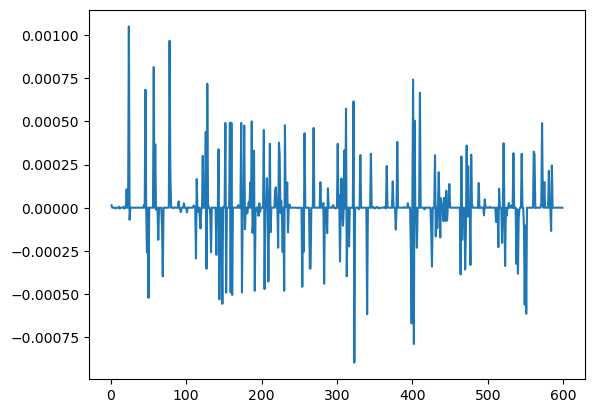

In [ ]:
plt.plot(full_book_df[full_book_df["time_id"] == 5]['log_return'])

Now let's add the Fourier transforms. We'll do PCA on top of this. The benefit of the Fourier transform is to make things shift-independent. So if a pattern happens at times 100-110, the same pattern at times 220-230 can get picked up. To do this, I'm going to put the dataframe into a numpy tensor so that we can do the Fourier transform in parallel. I'll leave it in the tensor for now for the sake of PCA.

In [ ]:
num_times = len(full_book_df['time_id'].unique())
num_seconds = len(full_book_df['seconds_in_bucket'].unique())
# the below could be useful
# original_col_names = list(full_book_df.columns)
# fourier_col_names = ["fft_" + name for name in original_col_names if name not in ('time_id', 'seconds_in_bucket')]
# new_col_names = original_col_names + fourier_col_names

book_tensor = full_book_df.drop(['time_id', 'seconds_in_bucket'], axis=1).to_numpy(dtype='float').reshape(num_times, num_seconds, -1)
fourier = np.fft.fft(book_tensor, axis=1)

# now fourier has complex entries. This isn't so nice for working with, so we'll split the complex numbers into real and imaginary
real, imag = np.real(fourier), np.imag(fourier)
fourier = np.concatenate([real, imag], axis=-1)
print(f"Fourier shape: {fourier.shape}. This is datapoints, timesteps, features. Features has doubled since we have real + imaginary")

Fourier shape: (3830, 599, 20). This is datapoints, timesteps, features. Features has doubled since we have real + imaginary


At this point, if we do PCA, we'll end up leaking data from the validation set. We also need to standardize our variables (on the training set only). So we really need to do some train/test split.

In [ ]:
train_proportion = .8
train_cutoff_index = int(train_proportion*fourier.shape[0])

fourier_train, fourier_test = np.split(fourier, [train_cutoff_index,])
train_mean = np.mean(fourier_train, axis=(0, 1))
train_std = np.std(fourier_train, axis=(0, 1))
normalized_train = (fourier_train-train_mean)/train_std
# we use the train_std and train_mean since that's what we do PCA on.
normalized_test = (fourier_test-train_mean)/train_std

Now we can run PCA on the train dataset. It takes my computer about 10 seconds, so it's not too slow. If this runs out of memory, we can switch to incremental PCA. I'll keep 10 dimensions (10 was selected by an elbow method).

In [ ]:
n_components = 10
fourier_pca = sklearn.decomposition.PCA(n_components)
fourier_pca.fit(normalized_train.reshape([normalized_train.shape[0], -1]))

# if we want to visualize the amount of variance explained, we can increase n_components and then plot the following
# plt.plot(fourier_pca.explained_variance_ratio_)

PCA(n_components=10)

Finally, we want to capture these components as features.

In [ ]:
train_features = fourier_pca.transform(normalized_train.reshape([normalized_train.shape[0], -1]))
test_features = fourier_pca.transform(normalized_test.reshape([normalized_test.shape[0], -1]))

In [ ]:
indices = full_book_df['time_id'].unique()
train_indices = indices[:train_cutoff_index].reshape(-1, 1)
test_indices = indices[train_cutoff_index:].reshape(-1, 1)

col_names = ['time_id'] + ['pca_' + str(i) for i in range(n_components)]
train_df = pd.DataFrame(data=np.concatenate((train_indices, train_features), axis=1),  columns=col_names)
test_df = pd.DataFrame(data=np.concatenate((test_indices, test_features), axis=1),  columns=col_names)

# change time_id back to integer
train_df = train_df.astype({'time_id': int})
test_df = test_df.astype({'time_id': int})

Now `train_df` and `test_df` contain all the PCA features. They are ready to be used with `target_df`. Note that `target_df` has not yet been split into training and testing sets.